# Mode d'emploi sur l'utilisation de la librairie

#### Import des sous modules de la librairie

In [6]:
from kernel.tools import CalendarConvention
from kernel.market_data import InterpolationType, VolatilitySurfaceType, Market, RateCurveType

In [7]:
from kernel.products.options.vanilla_options import EuropeanCallOption
from kernel.models import MCPricingEngine, HestonMCPricingEngine, EulerSchemeType
import numpy as np
import pandas as pd
from scipy.stats import norm

#### Informations renseignées par l'utilisateur (sur l'interface)

In [8]:
security = "S&P500"
rate_curve_type = RateCurveType.RF_US_TREASURY
interpolation_type = InterpolationType.SVENSSON
volatility_surface_type = VolatilitySurfaceType.SVI
calendar = CalendarConvention.ACT_360
scheme = EulerSchemeType.EULER

#### Initialisation du marché

In [9]:
market = Market(underlying_name=security,
                rate_curve_type=RateCurveType.RF_US_TREASURY,
                interpolation_type=InterpolationType.SVENSSON,
                volatility_surface_type=VolatilitySurfaceType.SVI,
                calendar_convention=CalendarConvention.ACT_360)

#### Initialisation du pricer et du produit à pricer

In [5]:
call_option = EuropeanCallOption(maturity=2, strike=market.underlying_asset.last_price)
engine = MCPricingEngine(market=market, discretization_method=scheme, nb_paths=100000, nb_steps=2)

#### Pricing

In [6]:
price = engine.compute_price(call_option)
print(price)

20.223990444229152


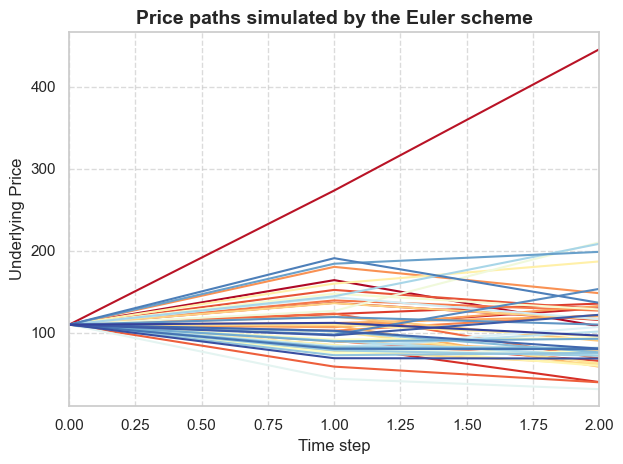

In [7]:
engine.plot_paths(call_option, nb_paths_plot=50)

#### Pricing with stochastic volatility

In [8]:
scheme = EulerSchemeType.HESTON_EULER
engine = HestonMCPricingEngine(market=market, discretization_method=scheme, nb_paths=100000, nb_steps=200)

In [9]:
price = engine.compute_price(call_option)
print(price)

27.269159627457647


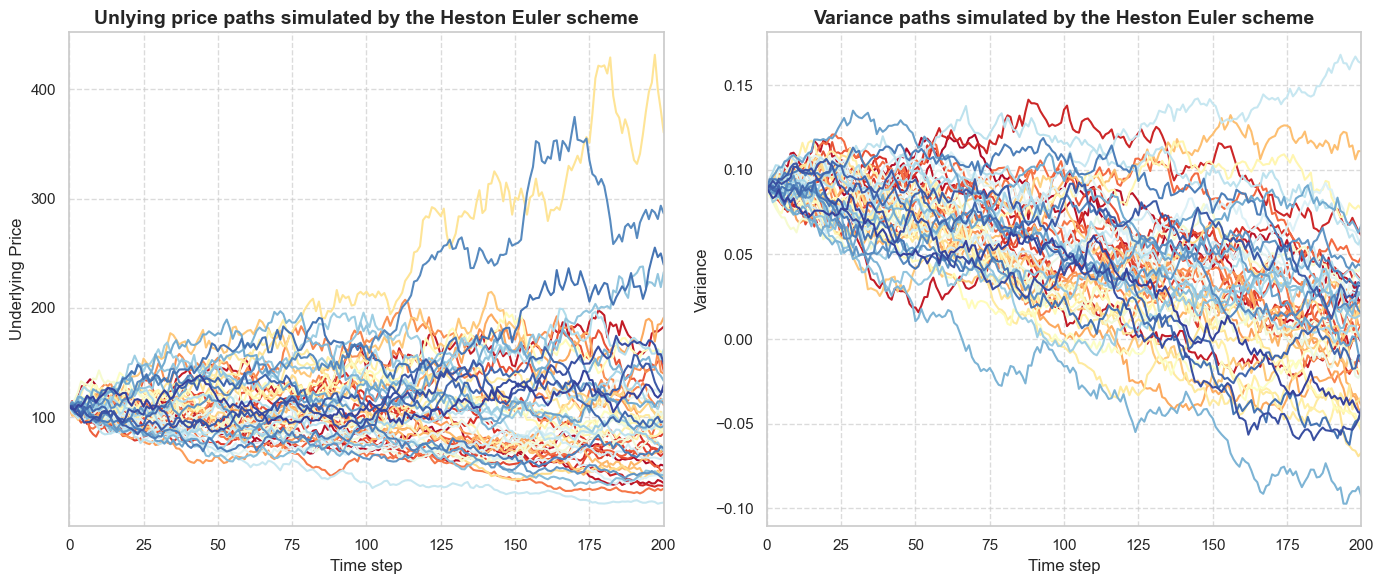

In [10]:
engine.plot_paths(call_option, nb_paths_plot=50, plot_variance=True)

#### Calcul des grecques

In [11]:
greeks = engine.compute_greeks(call_option)
print(greeks)

           Delta    Gamma  Vega     Theta  Rho
Greeks  0.643105  0.03185   0.0 -2.817944  0.0


#### Comparaison avec la formule fermée

In [12]:
def black_scholes(S, K, T, sigma, option_type="call"):
    """
    Calcule le prix d'une option européenne avec le modèle Black-Scholes.

    :param S: Prix actuel du sous-jacent
    :param K: Strike (prix d'exercice)
    :param T: Temps jusqu'à l'expiration en années
    :param sigma: Volatilité implicite
    :param option_type: "call" ou "put"
    :return: Prix de l'option
    """
    r = market.get_rate(T) / 100
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

In [13]:
closed_form_price = black_scholes(S=market.underlying_asset.last_price, K=call_option.strike, 
                                  T=call_option.maturity, sigma=market.get_volatility(call_option.strike, call_option.maturity*252))
print(closed_form_price)

20.233291728696777


## --------------------------------------------------------------------------------------------------

#### Exemples d'utilisation des informations stockées dans le marché

In [6]:
print(f"Taux 1.2Y interpolé: {round(market.get_rate(1.2),2)}%")
print(f"Volatilité K=220, T=24 jours interpolée: {round(market.get_volatility(220, 24),2)}%")

Taux 1.2Y interpolé: 1.91%
Volatilité K=220, T=24 jours interpolée: 0.17%


#### Visualisation de l'interpolation de la courbe de taux

c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term1 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:47: RuntimeWarning: invalid value encountered in scalar divide
  term2 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:48: RuntimeWarning: invalid value encountered in scalar divide
  term3 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))


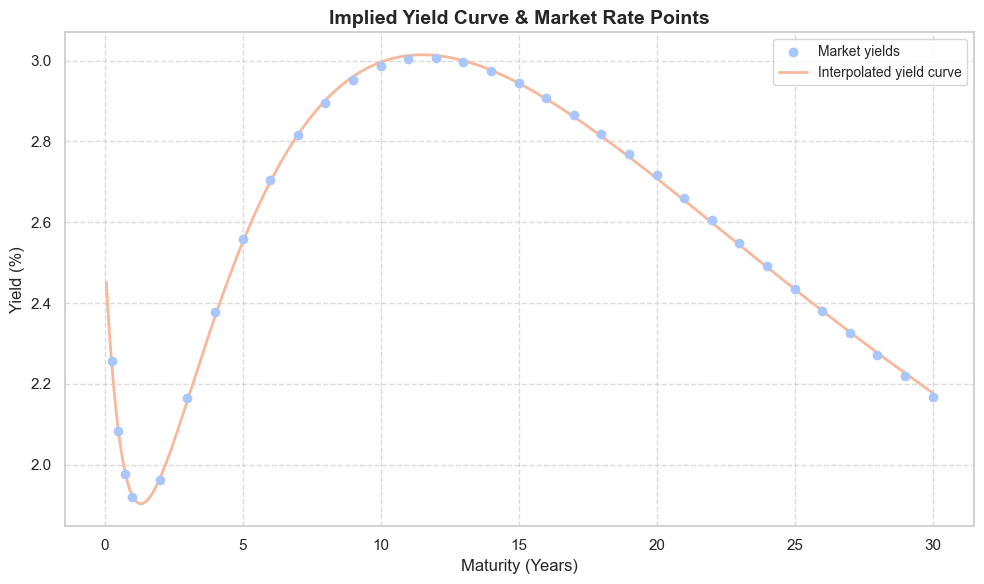

In [6]:
market.rate_curve.display_curve()

#### Visualisation de la surface de volatilité

In [9]:
print(market.volatility_surface.option_data)

     Maturity  Strike  Implied Volatility    Spot  Log Moneyness
0    0.019231  3461.2              0.9579  5768.0      -0.510710
1    0.038462  3461.2              0.7903  5768.0      -0.510710
2    0.057692  3461.2              0.7046  5768.0      -0.510710
3    0.083333  3461.2              0.6301  5768.0      -0.510710
4    0.096154  3461.2              0.6082  5768.0      -0.510710
..        ...     ...                 ...     ...            ...
337  0.833333  8653.1              0.1689  5768.0       0.405592
338  1.000000  8653.1              0.1544  5768.0       0.405592
339  1.500000  8653.1              0.1277  5768.0       0.405592
340  2.000000  8653.1              0.1192  5768.0       0.405592
341  3.000000  8653.1              0.1249  5768.0       0.405592

[342 rows x 5 columns]


c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\volatility_surface\svi_volatility.py:157: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(total_variance / maturity)


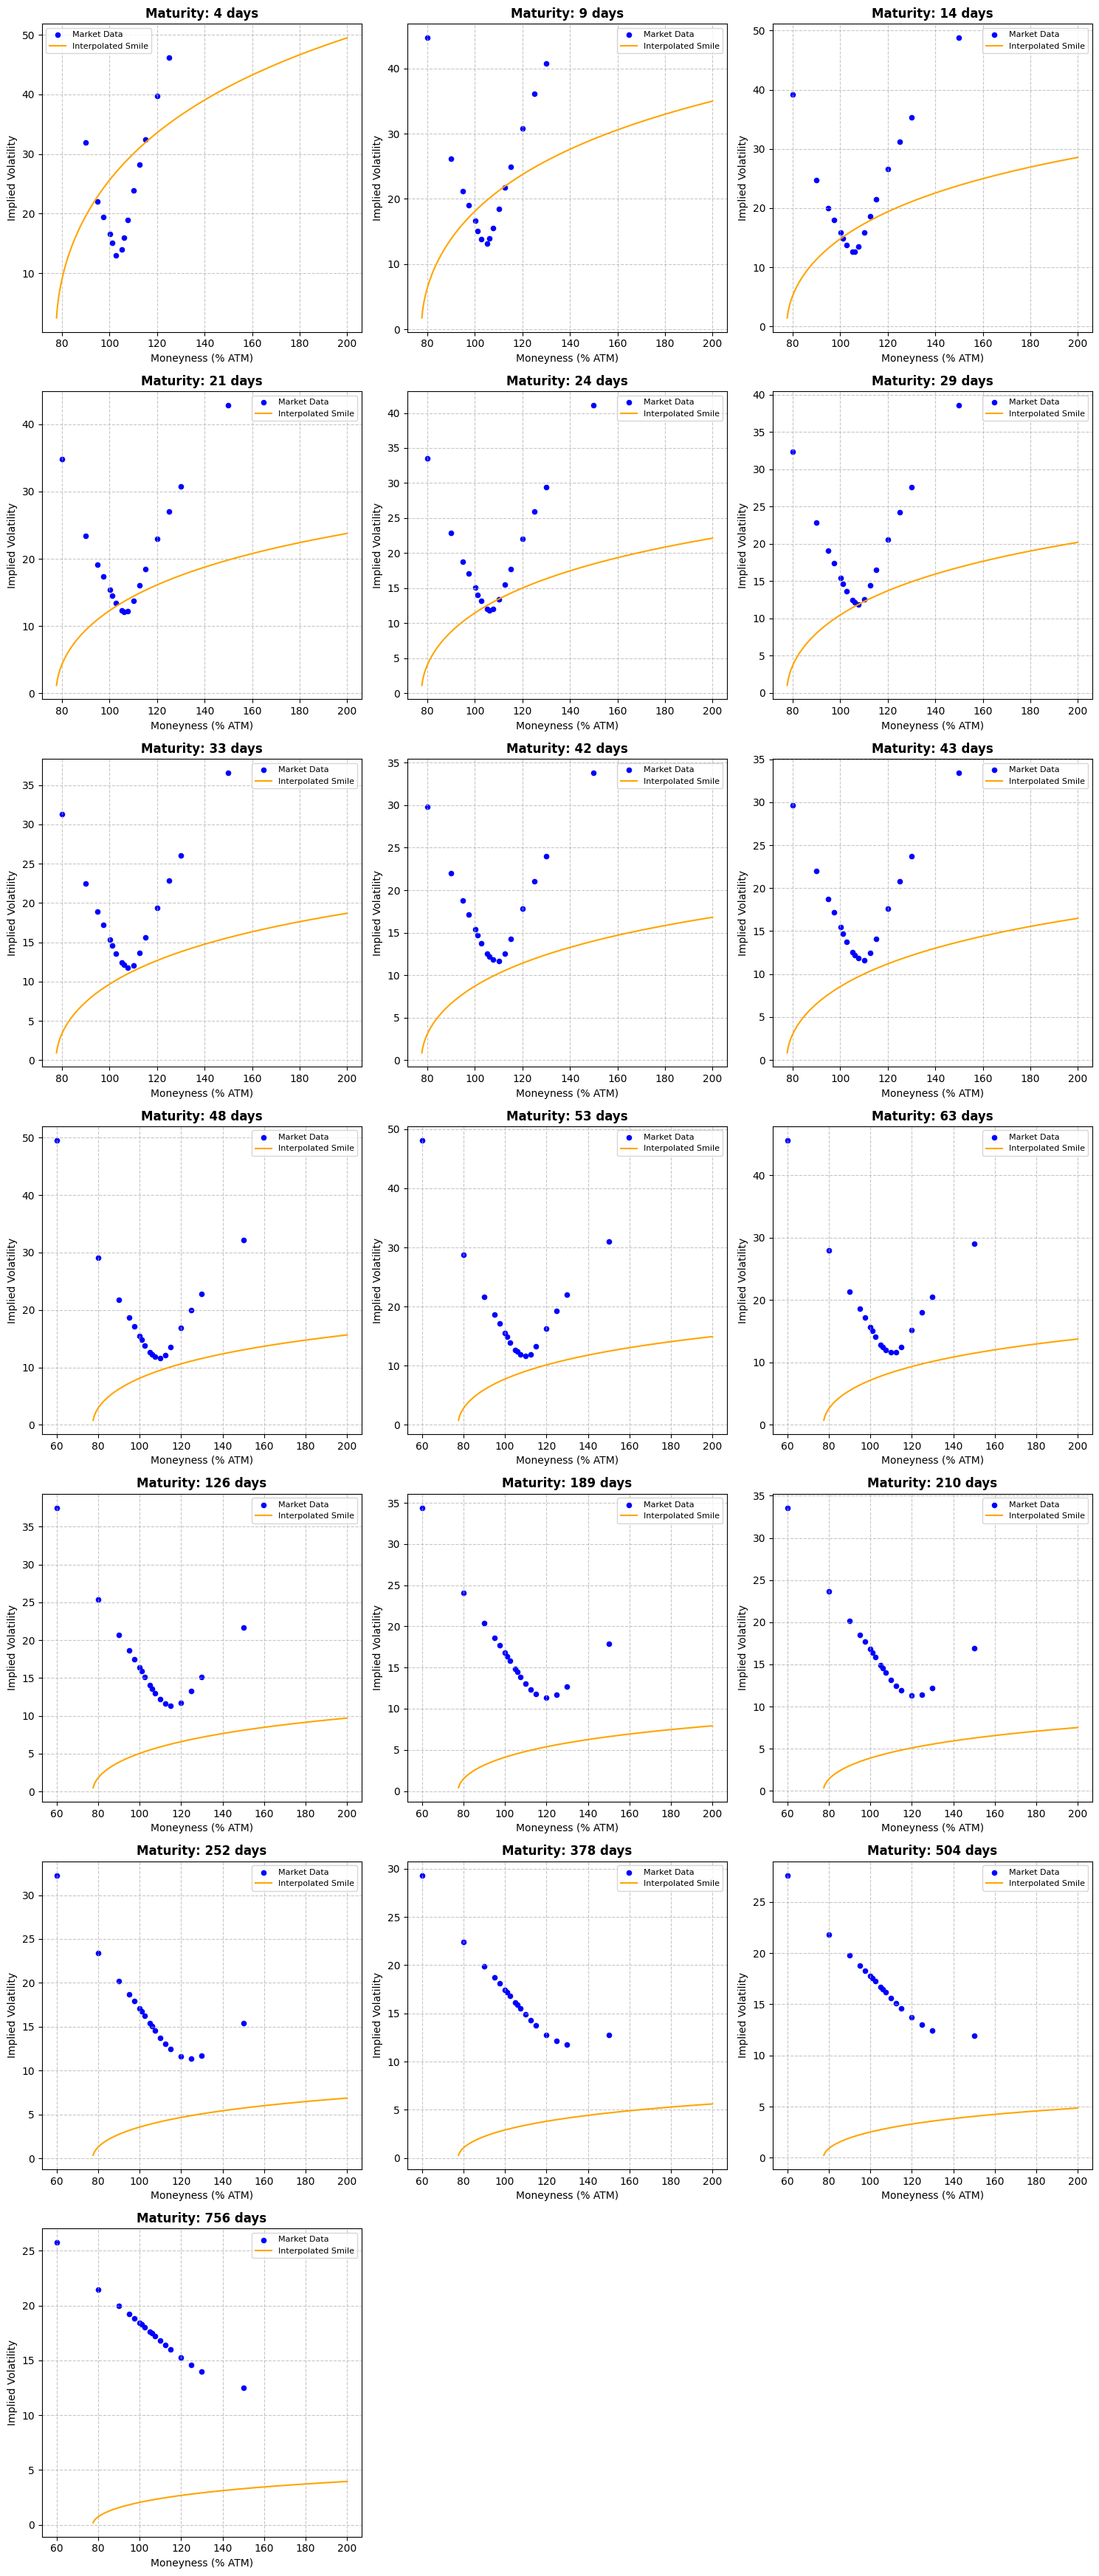

In [10]:
market.volatility_surface.display_smiles()

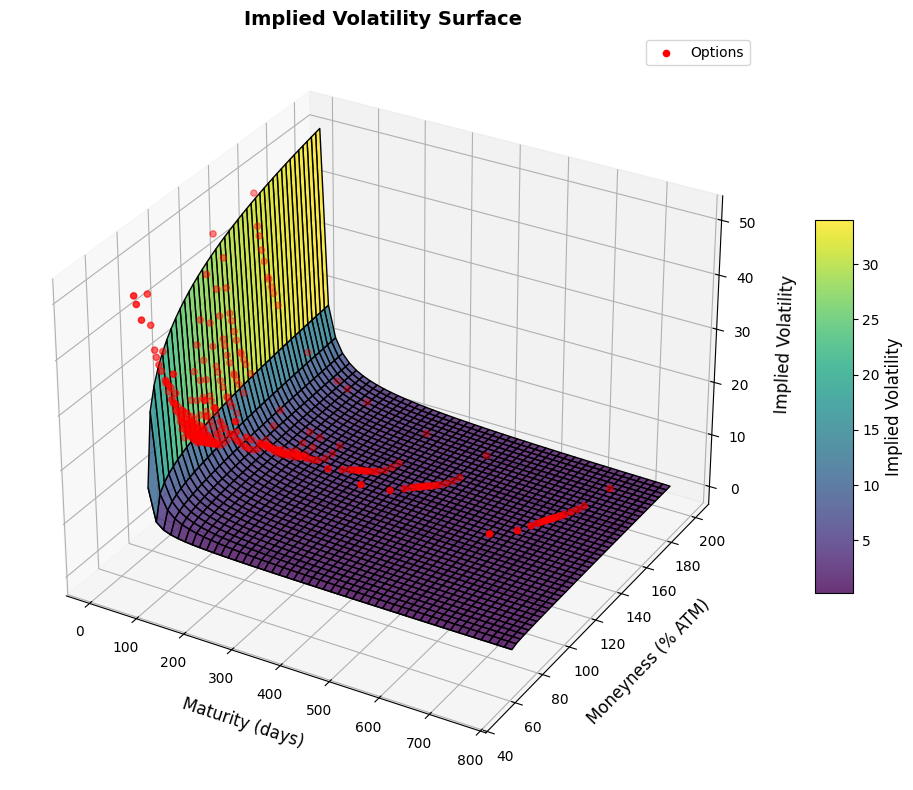

In [11]:
market.volatility_surface.display_surface()